# 📘 MNIST Curve Adjustment Layers (CALs) — Experimental Baseline

## 🧠 Overview

In this notebook, we establish a **strong and interpretable control model** on the **MNIST handwritten digit classification task**, forming the **foundation for our exploration of Curve Adjustment Layers (CALs)** — a novel technique aimed at improving neural network convergence and generalization.

CALs act as *intermediary modules* between neural layers, applying **learned deformation curves** to activations. These curves serve to *bend the output space* toward more optimal configurations, enabling the model to adaptively reshape internal representations.

This notebook provides:
- ✅ A solid CNN-based reference model
- 📥 MNIST dataset loading and visualization
- 🧰 Preliminaries for future CAL insertion and ablation studies

---


### 💽 Install any packages needed ...

In [ ]:
!pip install matplotlib

In [10]:
import os
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# Grab the MNIST Dataset:
---

The MNIST dataset is a collection of 70,000 handwritten digits (0-9) that is commonly used for training various image processing systems.


## 📊 Dataset Summary: MNIST

- **Type**: Grayscale handwritten digits  
- **Size**: `60,000` training / `10,000` test samples  
- **Resolution**: `28×28` pixels  
- **Classes**: Digits `0–9`  

---

In [ ]:
# Download MNIST dataset to a local directory:
# M:\dev\ml\data

# Create the transform function to convert the image to a tensor and normalize it:
# (Note: The normalization values are based on the MNIST dataset statistics.)
tx = transforms.Compose( [
    transforms.ToTensor( ),
    transforms.Normalize( ( 0.1307, ), ( 0.3081, ) ),
] )

data_path = os.path.join('..', 'data')
mnist_train = datasets.MNIST( data_path, train=True, download=True, transform=tx )
mnist_test  = datasets.MNIST( data_path, train=False, download=True, transform=tx )
print( "MNIST dataset downloaded to:", data_path )

count_train = len( mnist_train )
count_test = len( mnist_test )

MNIST dataset downloaded to: ..\data


# Examine the data:
---

Read data samples and view the image and label ...

In [12]:
import torch
print( "Number of training samples:", count_train )
print( "Number of test samples:", count_test )

# Examine data samples:
img, label = mnist_train[ torch.randint( 0, count_train, ( ) ) ]
print( "Image:", img, "Label:", label )

# Display the first image:
img.show( )

Number of training samples: 60000
Number of test samples: 10000
Image: <PIL.Image.Image image mode=L size=28x28 at 0x2752503AED0> Label: 2


## 📦 Data Loader & Hyperparameter Setup

To train our CNN model efficiently, we define a few key **training hyperparameters** and configure a **data preprocessing pipeline** that prepares the MNIST dataset for use in PyTorch.

---

### 🎛️ Training Hyperparameters

| Hyperparameter   | Value      | Description                                                       |
|------------------|------------|-------------------------------------------------------------------|
| `batch_size`     | `64`       | Number of samples per batch — balances speed and gradient quality |
| `epochs`         | `5`        | Total passes over the training set                               |
| `lr`             | `0.001`    | Learning rate — controls optimizer step size                      |

---


In [16]:
# Hyperparameters
n_batch = 64
epochs = 5
lr = 0.001

# Create a DataLoader to load the dataset in batches:
data_loader = DataLoader( mnist_train,
                          batch_size=n_batch,
                          shuffle=True )



# 🧠 MNIST Control Model Architecture Overview

## 🎯 Objective

This notebook establishes a **well-performing, yet minimal and interpretable convolutional neural network (CNN)** designed to solve the **MNIST handwritten digit classification problem**. Our intent is to create a **robust "control" architecture** for later comparative experiments involving more advanced or experimental models. MNIST is a widely used benchmark dataset for evaluating model performance in image recognition tasks.

---


## 🧱 Model Architecture

A lightweight yet competitive CNN inspired by classical deep learning pipelines.

| Layer              | Type            | Shape In → Out      | Activation | Notes                         |
|--------------------|------------------|----------------------|------------|-------------------------------|
| 🔹 Input           | Image            | `1 × 28 × 28`        | –          | Grayscale digit image         |
| 🔸 Conv1           | Conv2d(1→32, 3×3) | `28 × 28 → 28 × 28`  | ReLU       | Padding preserves resolution  |
| 🔸 MaxPool1        | MaxPool2d(2×2)   | `28 × 28 → 14 × 14`  | –          | Downsamples feature maps      |
| 🔸 Conv2           | Conv2d(32→64, 3×3)| `14 × 14 → 14 × 14` | ReLU       | Captures mid-level patterns   |
| 🔸 MaxPool2        | MaxPool2d(2×2)   | `14 × 14 → 7 × 7`    | –          | Further spatial reduction     |
| 🔸 Flatten         | –                | `64 × 7 × 7 → 3136`  | –          | Prep for dense layers         |
| 🔸 FC1             | Linear(3136→128) | `3136 → 128`         | ReLU       | Dense representation          |
| 🔸 Dropout         | Dropout(p=0.25)  | `128 → 128`          | –          | Regularization against overfit|
| 🔸 FC2             | Linear(128→10)   | `128 → 10`           | –          | Raw class logits (pre-Softmax)|

---

## ⚙️ Design Rationale

### ✅ Simplicity with Performance
This architecture balances **simplicity**, **speed**, and **performance**, achieving **~99% accuracy** on MNIST while remaining **transparent and modifiable**.

### 🧩 Key Design Choices

- **2× Convolution Layers**: Enough for capturing local and mid-level features on 28×28 inputs.
- **MaxPooling**: Reduces computation, introduces translational invariance.
- **Dropout**: Prevents overfitting in dense layers, especially for small datasets.
- **ReLU Activations**: Promote fast convergence and sparse gradients.
- **Minimal FC layers**: Keeps parameter count low without sacrificing accuracy.

---

## 🧪 Purpose in Research

This model acts as a **baseline control** for later experiments involving:

- Architectural modifications (residuals, batch norm, transformers, etc.)
- Alternative optimization strategies (SGD vs AdamW)
- Ablation studies
- Regularization and generalization research

It serves as a **trustworthy metric anchor** to assess whether newer approaches offer real improvements or are overly complex.

---

## 📈 Performance Baseline

With standard hyperparameters:

```python
epochs = 5
batch_size = 64
optimizer = Adam(lr=1e-3)
loss_fn = CrossEntropyLoss()


In [17]:
# Define a convolutional neural network (CNN) model
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN model
class MNISTNet( nn.Module ):
    def __init__( self ):
        """
        Initialize the CNN model.
        """
        
        super( ).__init__( )
        
        # Define the layers of the CNN:
        self.conv1 = nn.Conv2d( 1, 32, 3, padding=1 )
        self.conv2 = nn.Conv2d( 32, 64, 3, padding=1 )
        self.pool = nn.MaxPool2d( 2, 2 )
        self.fc1 = nn.Linear( 64 * 7 * 7, 128 )
        self.dropout = nn.Dropout( 0.25 )
        self.fc2 = nn.Linear( 128, 10 )

    def forward( self, x ):
        """
        Define the forward pass of the model.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor.
        """
        # Apply the convolutional layers, activation functions, and pooling:
        # (Note: The input tensor is expected to have shape [batch_size, 1, 28, 28])
        x = self.pool( torch.relu( self.conv1(x) ) )
        x = self.pool( torch.relu( self.conv2(x) ) )
        x = torch.flatten( x, 1 )
        x = self.dropout( torch.relu( self.fc1(x) ) )
        x = self.fc2( x )
        return x


## 🚂 Model Training Loop

With the data loaders and architecture in place, we now define and execute the **training loop** to optimize the model parameters using backpropagation.

This loop follows a typical supervised learning pattern:
1. 🔄 Load a batch of input images and labels
2. 🧮 Forward pass through the network
3. 🎯 Compute the loss against ground truth
4. 🔁 Backpropagate gradients
5. 🛠️ Update model weights via optimizer

---

### ⚙️ Optimizer & Loss Function

```python
import torch.nn as nn
import torch.optim as optim

model = MNISTNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
```


In [18]:
# Create an instance of the model and use the GPU if available:
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
model  = MNISTNet( ).to( device )

# Define loss function and optimizer:
loss_fn   = nn.CrossEntropyLoss( )
optimizer = optim.Adam( model.parameters( ), lr=lr )

# Training the model:
for epoch in range( epochs ):
    model.train( )  # Set the model to training mode
    running_loss = 0.0
    
    for images, labels in data_loader:
        images, labels = images.to( device ), labels.to( device )

        # Zero gradients from previous step
        optimizer.zero_grad( )

        # Forward pass
        outputs = model( images )

        # Compute loss
        loss = loss_fn( outputs, labels )

        # Backpropagation
        loss.backward( )

        # Update weights
        optimizer.step( )

        # Accumulate loss
        running_loss += loss.item( )

    print( f"📘 Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f}" )


📘 Epoch 1/5 - Loss: 139.1940
📘 Epoch 2/5 - Loss: 49.5114
📘 Epoch 3/5 - Loss: 36.0982
📘 Epoch 4/5 - Loss: 27.2234
📘 Epoch 5/5 - Loss: 22.1077


# 📁 Saving the model ...

## ✅ Recommended: Save Model Weights (State Dict)
> This is the standard, flexible approach for reloading models in code.

### 🔐 Save:
```python
torch.save( model.state_dict(), "mnist_cnn.pth" )
```

### 🔁 Load:
```python
model = MNISTNet( ).to( device )
model.load_state_dict( torch.load("mnist_cnn.pth") )
model.eval( ) # Important for inference mode (dropout, etc.)
```

---

## 🧱 Alternative: Save Full Model (Not Recommended Long-Term)
```python
torch.save( model, "mnist_full_model.pth" )
```

And to load:
```python
model = torch.load("mnist_full_model.pth")
model.eval()
```

### ⚠️ Caution: This approach serializes the full model structure and class. It:
- Breaks if the source code changes
- Isn’t portable across versions or environments
___

In [19]:
filename = 'mnist_cnn.pth'
model_output_dir = os.path.join( '..', 'models' )
model_output_path = os.path.join( model_output_dir, filename )

if not os.path.exists( model_output_dir ):
    os.makedirs( model_output_dir )
    
# Save the trained model
torch.save( model.state_dict( ), model_output_path )
print( "Model saved to:", model_output_path )

Model saved to: ..\models\mnist_cnn.pth


# 🧪 Quick Check: Inference After Load

In [ ]:
# Load the model if not already loaded
filename = 'mnist_cnn.pth'
model_output_dir = os.path.join( '..', 'models' )
load_path = os.path.join( model_output_dir, filename )

model = MNISTNet( ).to( device )
model.load_state_dict( torch.load( load_path ) )

In [30]:
# Test the model on a single image
model.eval( )
with torch.no_grad( ):
    # Load a test image:
    image, label = mnist_test[ 990 ]
    image = tx( image ).unsqueeze( 0 ).to( device )

    # Make prediction:
    output = model( image )
    pred = output.argmax( dim=1 ).item( )
    print( f"Predicted: {pred}, Ground Truth: {label}" )

Predicted: 2, Ground Truth: 2


## 📊 Evaluation Loop & Accuracy Visualization

Once the model is trained, we run an evaluation pass over the test set to:
- Compute total accuracy
- Track predictions across all batches
- Plot a performance summary graph

---


In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Rebuild test dataset with transform applied
mnist_test = datasets.MNIST( data_path, train=False, download=True, transform=tx )

# Create test DataLoader
test_loader = DataLoader( mnist_test, batch_size=64, shuffle=False )

# Set model to evaluation mode
model.eval( )

total   = 0
correct = 0
losses        = [ ]
predictions   = [ ]
ground_truths = [ ]

with torch.no_grad( ):
    for images, labels in test_loader:
        images, labels = images.to( device ), labels.to( device )

        outputs = model( images )
        loss = loss_fn( outputs, labels )
        losses.append( loss.item() )

        _, predicted = torch.max( outputs.data, 1 )
        predictions.extend( predicted.cpu().numpy() )
        ground_truths.extend( labels.cpu().numpy() )

        correct += (predicted == labels).sum( ).item( )
        total += labels.size( 0 )

accuracy = 100.0 * correct / total
print( f"✅ Test Accuracy: {accuracy:.2f}%")
print( f"Total Images: {total}, Correct Predictions: {correct}" )

✅ Test Accuracy: 98.93%
Total Images: 10000, Correct Predictions: 9893


# 📈 Performance Visualizations:

---

### Batch Loss Over Evaluation
> 📊 What It Represents
 - X-Axis (Batch Index): Each point represents a batch of 64 test images in order of evaluation.

 - Y-Axis (Loss): The loss value for that batch (i.e., how well the model's predictions matched the ground truth for that specific batch).

---


C:\Users\atcar\AppData\Local\Temp\ipykernel_35376\2244420741.py:8: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\atcar\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


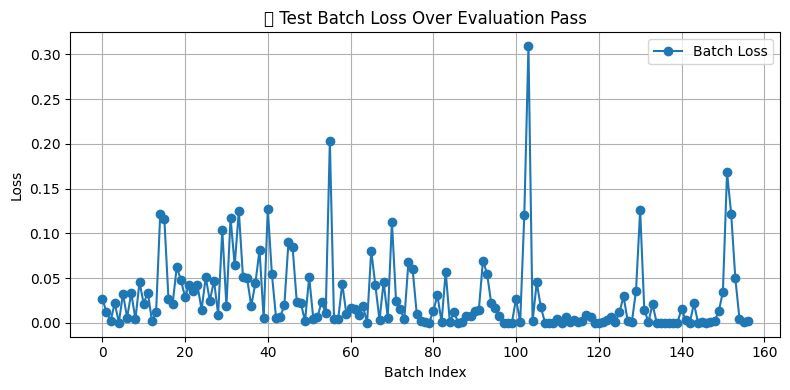

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(losses, marker='o', linestyle='-', label="Batch Loss")
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("📉 Test Batch Loss Over Evaluation Pass")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
